In [66]:
# changed imports (Phase2)
import os
import uuid
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras

# new imports to phase 2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

from tensorflow.keras.optimizers import Adam
from SwarmPackagePy import gsa
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import pandas as pd  # Import the Pandas library
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc

In [65]:
train_dir = "..\isec-ic\\dataset\\train"
validation_dir = "..\isec-ic\\dataset\\valid"
test_dir = "..\isec-ic\\dataset\\test"

#output_dir = "results\\" # 10 classes (included earlyblight and targetspot)
output_dir = "base_results\\"  # excluded earlyblight and targetspot

current_dir = os.path.dirname(os.path.realpath(__file__ if '__file__' in locals() else os.getcwd()))

train_dir = os.path.join(current_dir, train_dir)
validation_dir = os.path.join(current_dir, validation_dir)
test_dir = os.path.join(current_dir, test_dir)

#  "lateblight","bacterialspot", "healthy",  "leafmold", "mosaicvirus","yellowleafcurlvirus" ,"spidermite","septorialeafspot"
categories = ["earlyblight",  "targetspot"]

In [67]:
def load_images_from_folder(folder):
    images = []
    labels = []
    subfolders = os.listdir(folder)  # list of subfolders in the main folder
    
    for subfolder in subfolders:
        category = subfolder.split("_")[-1].lower()  # category of the subfolder (e.g., "scab" from "Apple___Apple_scab")
        
        if category in categories:
            print("Loading images from category: " + category + " and subfolder: " + subfolder)
            subfolder_path = os.path.join(folder, subfolder)
            
            for filename in os.listdir(subfolder_path):
                img = Image.open(os.path.join(subfolder_path, filename))
                img = img.resize((64, 64)) # default is 256
                img = np.array(img) / 255.0  # normalization of the pixel values between 0 and 1
                images.append(img)
                labels.append(categories.index(category))  # index of the category in the list of categories
        else:
            print("Category: " + category + " from subfolder " + subfolder + " is not in the list of categories.")

    return np.array(images), np.array(labels)

In [69]:
x_train, y_train = load_images_from_folder(train_dir)
print("Finished to load the train images")

x_validation, y_validation = load_images_from_folder(validation_dir)
print("Finished to load the validation images")

x_test, y_test = load_images_from_folder(test_dir)
print("Finished to load the test images");

Loading images from category: spidermite and subfolder: Tomato__spidermite
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Loading images from category: earlyblight and subfolder: Tomato___Earlyblight
Loading images from category: healthy and subfolder: Tomato___healthy
Loading images from category: lateblight and subfolder: Tomato___Lateblight
Loading images from category: leafmold and subfolder: Tomato___Leafmold
Loading images from category: septorialeafspot and subfolder: Tomato___Septorialeafspot
Loading images from category: targetspot and subfolder: Tomato___Targetspot
Loading images from category: mosaicvirus and subfolder: Tomato___Tomato_mosaicvirus
Loading images from category: yellowleafcurlvirus and subfolder: Tomato___Tomato_yellowleafcurlvirus
Finished to load the train images
Loading images from category: bacterialspot and subfolder: Tomato___Bacterialspot
Loading images from category: earlyblight and subfolder: Tomato___Earlyblight
Loa

In [75]:
total_epochs = 10
model_uuid = uuid.uuid4()
learning_rate = 0.001
optimizer_name = "adam"
loss_function = "sparse_categorical_crossentropy"
size_img = "64x64"

# Display the total number of images loaded
print("Number of training images: " + str(len(x_train)))
print("Number of validation images: " + str(len(x_validation)))
print("Number of test images: " + str(len(x_test)))

optimizer = Adam(learning_rate=learning_rate)

Number of training images: 15000
Number of validation images: 4000
Number of test images: 1000


In [71]:
from SwarmPackagePy import gsa

# Configurações da CNN
input_shape = (64, 64, 3)
num_classes = len(categories)

# Função para criar o modelo CNN
def create_cnn_model(num_layers, num_neurons):
    num_layers = max(1, round(num_layers))
    
    model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
    ])

    for _ in range(num_layers):
        num_neurons = max(1, round(num_neurons))
        model.add(keras.layers.Conv2D(num_neurons, kernel_size=(3, 3), activation='relu', padding='same'))
        
        # Ajuste dinâmico do tamanho do pool
        current_shape = model.output_shape[1:3]
        pool_size = (min(2, current_shape[0]), min(2, current_shape[1]))
        
        model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    return model

# Função de avaliação para o GSA
def evaluate_model_GSA_CNN(solution):
    num_layers, num_neurons = solution
    model = create_cnn_model(num_layers, num_neurons)

    try:
        model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        #history = model.fit(x_train[:50], y_train[:50], epochs=5, validation_data=(x_validation[:25], y_validation[:25]), verbose=0)
        # history = model.fit(x_train[:10], y_train[:10], epochs=2, validation_data=(x_validation[:5], y_validation[:5]), verbose=0)
        history = model.fit(x_train[:5], y_train[:5], epochs=2, validation_data=(x_validation[:5], y_validation[:5]), verbose=0)

        y_pred = np.argmax(model.predict(x_test[:25]), axis=1)
        accuracy = accuracy_score(y_test[:25], y_pred)

        return 1 - accuracy
    except tf.errors.ResourceExhaustedError:
        return 1e6

# Configurações do GSA
num_agents = 1
max_iter = 3
G0 = 100
alpha = 20
min_mass = 1
bounds = [(1, 3), (12,120)]

# Inicialização
agents = np.random.uniform(low=np.array([bound[0] for bound in bounds]), high=np.array([bound[1] for bound in bounds]), size=(num_agents, len(bounds)))
costs = np.array([evaluate_model_GSA_CNN(agent) for agent in agents])

# Iterações do GSA
for iteration in range(max_iter):
    # Atualização da massa
    masses = min_mass + (G0 / (1 + alpha * iteration)) * costs

    # Atualização da posição dos agentes
    forces = np.zeros_like(agents)
    for i in range(num_agents):
        for j in range(num_agents):
            if i != j:
                r = np.linalg.norm(agents[i] - agents[j])
                force = G0 * masses[i] * masses[j] * (agents[j] - agents[i]) / (r + 1e-8)
                forces[i] += force

    agents += forces
    costs = np.array([evaluate_model_GSA_CNN(agent) for agent in agents])

# Melhor solução encontrada
best_solution = agents[np.argmin(costs)]
best_num_layers, best_num_neurons = best_solution

print("finished")

1/1 [==============================] - 0s 52ms/step
finished


In [72]:
print("Melhor solução encontrada:")
print("Número de Camadas:", best_num_layers)
print("Número de Neurônios por Camada:", best_num_neurons)

Melhor solução encontrada:
Número de Camadas: 2.5721243332971158
Número de Neurônios por Camada: 65.77168264392425


In [76]:
total_epochs = 15

# Função para criar o modelo CNN com parâmetros otimizados
def create_cnn_model_optimized(num_layers, num_neurons):
    num_layers = max(1, round(num_layers))
    num_neurons = max(1, round(num_neurons))
    
    model = keras.Sequential([
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
    ])

    for _ in range(num_layers):
        model.add(keras.layers.Dense(num_neurons, activation='relu'))

    model.add(keras.layers.Dense(len(categories), activation='softmax'))

    return model

# Criar um novo modelo com os melhores parâmetros otimizados
best_cnn_model = create_cnn_model_optimized(int(best_num_layers), int(best_num_neurons))

# Compilar e treinar o modelo com os dados
best_cnn_model.compile(optimizer=optimizer, loss=loss_function, metrics=['accuracy'])
best_cnn_history = best_cnn_model.fit(x_train, y_train, epochs=total_epochs, validation_data=(x_validation, y_validation))

# Avaliar o desempenho do modelo treinado
best_cnn_train_accuracy = best_cnn_history.history['accuracy'][-1]
best_cnn_validation_accuracy = best_cnn_history.history['val_accuracy'][-1]

print("Melhor Accuracy de Treinamento (CNN):", best_cnn_train_accuracy)
print("Melhor Accuracy de Validação (CNN):", best_cnn_validation_accuracy)

Epoch 1/15
469/469 [==============================] - 10s 20ms/step - loss: 1.2007 - accuracy: 0.5802 - val_loss: 0.8005 - val_accuracy: 0.7155
Epoch 2/15
469/469 [==============================] - 9s 20ms/step - loss: 0.6180 - accuracy: 0.7896 - val_loss: 0.5828 - val_accuracy: 0.7960
Epoch 3/15
469/469 [==============================] - 9s 20ms/step - loss: 0.4497 - accuracy: 0.8467 - val_loss: 0.4699 - val_accuracy: 0.8393
Epoch 4/15
469/469 [==============================] - 9s 20ms/step - loss: 0.3579 - accuracy: 0.8783 - val_loss: 0.4310 - val_accuracy: 0.8530
Epoch 5/15
469/469 [==============================] - 9s 20ms/step - loss: 0.2758 - accuracy: 0.9080 - val_loss: 0.3797 - val_accuracy: 0.8723
Epoch 6/15
469/469 [==============================] - 9s 20ms/step - loss: 0.2186 - accuracy: 0.9283 - val_loss: 0.5721 - val_accuracy: 0.8102
Epoch 7/15
469/469 [==============================] - 9s 20ms/step - loss: 0.1704 - accuracy: 0.9432 - val_loss: 0.4035 - val_accuracy: 0.882

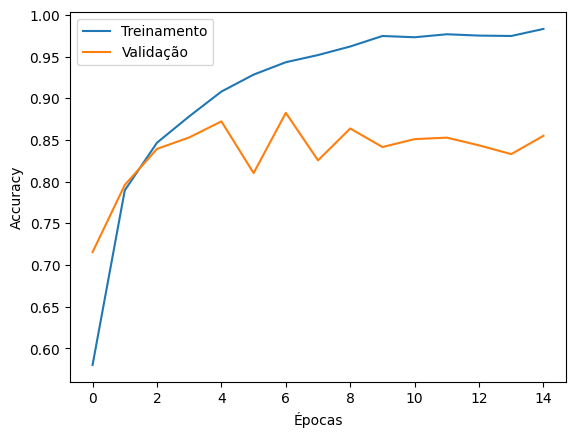

In [77]:

# Plotar as curvas de treino e validação
plt.plot(best_cnn_history.history['accuracy'], label='Treinamento')
plt.plot(best_cnn_history.history['val_accuracy'], label='Validação')
plt.xlabel('Épocas')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


32/32 [==============================] - 0s 5ms/step
Global Accuracy: 85.30%


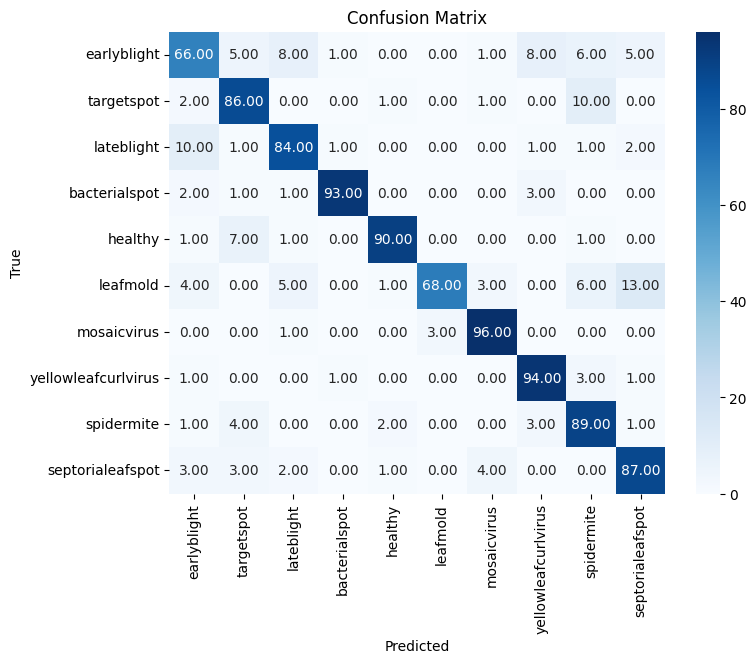

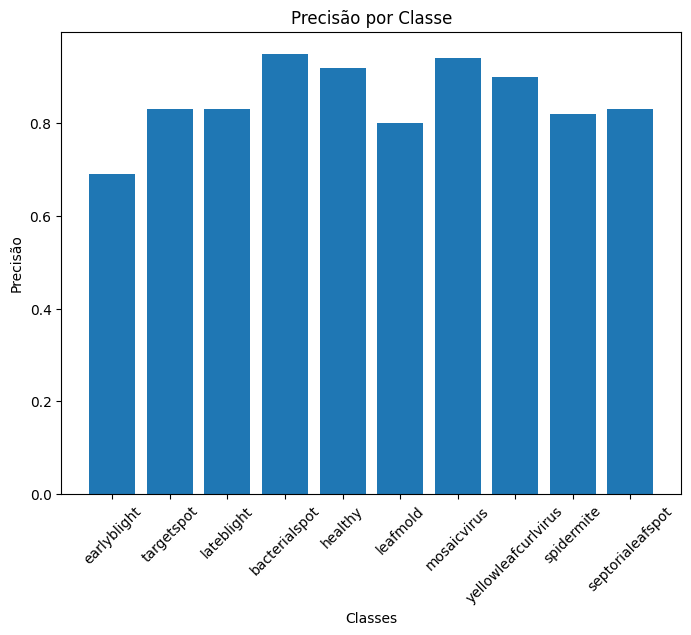

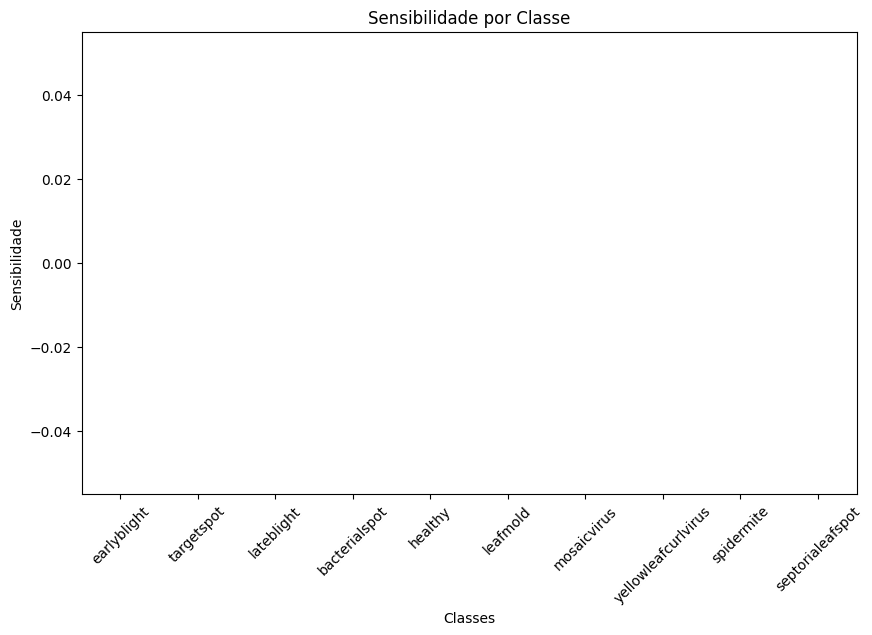

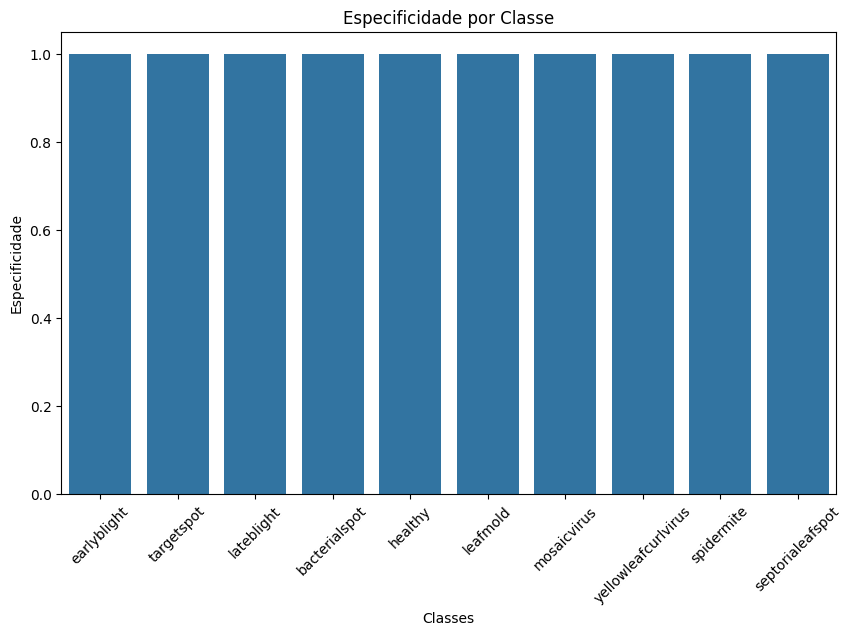

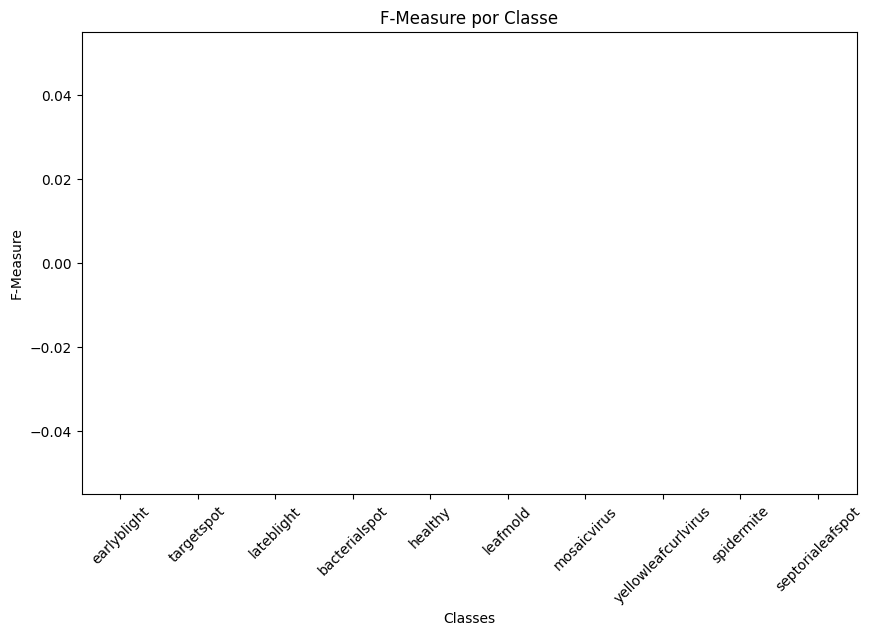

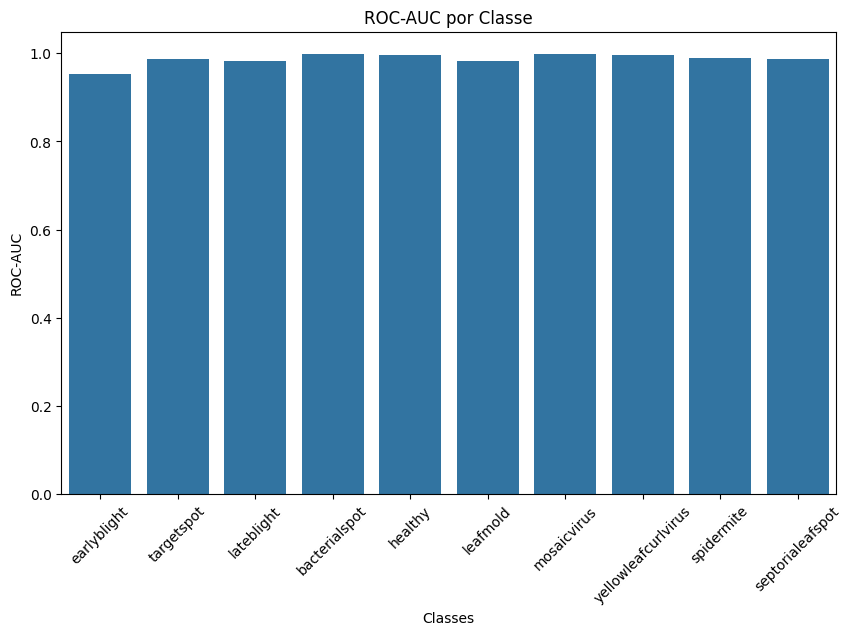

Model Saved Successfully: a197768e-0163-4ec4-9bb5-91f878027d96


In [78]:
total_classes_name = f"{str(len(categories))}_classes"

y_pred = best_cnn_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Cálculo da precisão global (global accuracy)
global_accuracy = accuracy_score(y_test, y_pred_classes)
print("Global Accuracy: {:.2f}%".format(global_accuracy * 100))

file_name_confusion = f"{output_dir}{model_uuid}_cnn_confusion_matrix_{optimizer_name}_lr{learning_rate}_epochs{total_epochs}_.png"
file_name_precision = f"{output_dir}{model_uuid}_cnn_precision_{optimizer_name}_lr{learning_rate}_epochs{total_epochs}.png"
model_file_name = f"{output_dir}{global_accuracy}_cnn_{model_uuid}_model_{optimizer_name}_lr{learning_rate}_epochs{total_epochs}.keras"

# Confusion Matrix
confusion = confusion_matrix(y_test, y_pred_classes)
row_sums = confusion.sum(axis=1, keepdims=True)
percent_confusion = (confusion / row_sums) * 100
plt.figure(figsize=(8, 6))
sns.heatmap(percent_confusion, annot=True, fmt=".2f", cmap="Blues", xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(file_name_confusion)
plt.show()


# Precission report
classification = classification_report(y_test, y_pred_classes, target_names=categories, zero_division=1)
categories_classification = []
precision = []
lines = classification.split('\n')
for line in lines[2:-3]:
    parts = line.split()
    if len(parts) >= 4:
        category = parts[0]
        p = float(parts[3])
        categories_classification.append(category)
        precision.append(p)
plt.figure(figsize=(8, 6))
plt.bar(categories_classification, precision)
plt.xlabel('Classes')
plt.ylabel('Precisão')
plt.title('Precisão por Classe')
plt.xticks(rotation=45)
plt.savefig(file_name_precision) 
plt.show()

# Cálculo das métricas ROC-AUC, sensibilidade, especificidade, F-Measure e AUC
n_classes = len(categories)
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array([1 if j == i else 0 for j in y_test]), y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Convert the list of categories into a pandas Categorical object
categories_df = pd.Categorical(categories, categories=categories)

# Sensitivities, Specificities, F-Measures, and AUC
sensitivities = [tpr[i][0] for i in range(n_classes)]
specificities = [1 - fpr[i][0] for i in range(n_classes)]
f_measures = [2 * (s * p) / (s + p) for s, p in zip(sensitivities, specificities)]
roc_auc_values = [roc_auc[i] for i in range(n_classes)]

# Gráfico de Sensibilidade
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=sensitivities)
plt.xlabel('Classes')
plt.ylabel('Sensibilidade')
plt.title('Sensibilidade por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de Especificidade
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=specificities)
plt.xlabel('Classes')
plt.ylabel('Especificidade')
plt.title('Especificidade por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de F-Measure
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=f_measures, errorbar='sd', capsize=0)  # Removido o cálculo do intervalo de confiança e as barras de erro
plt.xlabel('Classes')
plt.ylabel('F-Measure')
plt.title('F-Measure por Classe')
plt.xticks(rotation=45)
plt.show()

# Gráfico de AUC
plt.figure(figsize=(10, 6))
sns.barplot(x=categories_df, y=roc_auc_values)
plt.xlabel('Classes')
plt.ylabel('ROC-AUC')
plt.title('ROC-AUC por Classe')
plt.xticks(rotation=45)
plt.show()

# save the model 
best_cnn_model.save(model_file_name)
print("Model Saved Successfully: " + str(model_uuid));